## TIME SERIES FORECASTING: Autoregressive Integrated Moving Average (ARIMA)

### Import the necessary modules and plot the time series

<AxesSubplot:xlabel='Date', ylabel='ETo'>

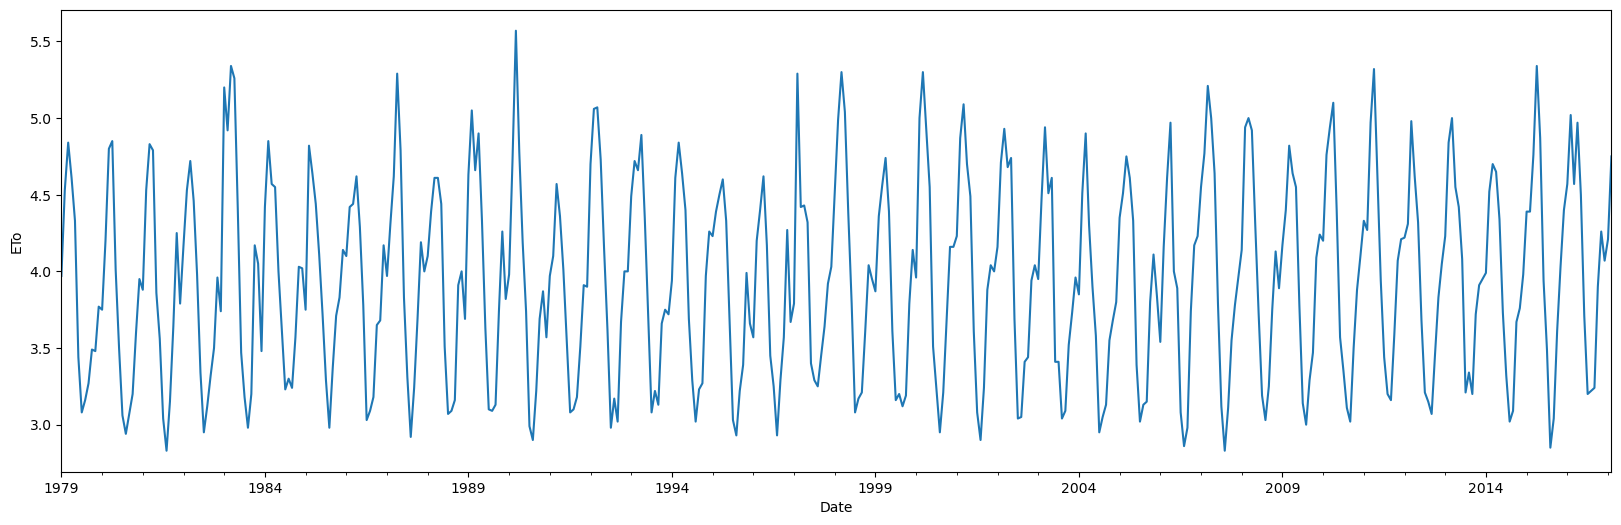

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
from datetime import datetime
os.chdir(r"C:\Users\USER\Desktop\ETo data")
data = read_csv('Abeokuta.csv', header = 6, names = ['Date', 'Temp min', 'Temp max', 'Wind speed', 'Sunlight hours','Solar Radiation', 'ETo'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
df = data['ETo']
plt.figure(figsize=(20, 6))
plt.ylabel('ETo')
df.plot()

### Data Split into Train and Test set

In [2]:
df_split = df.index < df.index[-30]
df_train = df[df_split].copy()
df_test = df[~df_split].copy()
print (df_train.shape, 
       df_test.shape)



(428,) (30,)


### Statistical test to check for stationarity of the time series

In [3]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


p-value: 8.014944708421601e-05


In [4]:
from pmdarima import auto_arima
# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [75]:
#Import Arima model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order = (12, 0, 25))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                    ETo   No. Observations:                  428
Model:               ARIMA(12, 0, 25)   Log Likelihood                  42.749
Date:                Thu, 11 Jan 2024   AIC                             -7.499
Time:                        20:24:37   BIC                            150.807
Sample:                    01-01-1979   HQIC                            55.023
                         - 08-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9298      0.074     53.168      0.000       3.785       4.075
ar.L1         -0.5292      0.901     -0.587      0.557      -2.295       1.236
ar.L2          0.1904      0.701      0.272      0.7

In [76]:
start = len(df_train)
end = len(df_train) + len(df_test)-1

prediction = model.predict(start=start, end=end, typ='levels')

In [77]:
comparison_df = pd.DataFrame({'Actual Values': df_test, 'Forecasted Values': prediction})
pd.set_option('display.max_rows', None)

# Print the DataFrame
print(comparison_df)

            Actual Values  Forecasted Values
2014-09-01           3.09           3.045814
2014-10-01           3.67           3.534211
2014-11-01           3.76           3.893451
2014-12-01           3.98           4.056552
2015-01-01           4.39           4.257989
2015-02-01           4.39           4.497467
2015-03-01           4.76           4.706969
2015-04-01           5.34           4.670812
2015-05-01           4.87           4.419790
2015-06-01           3.94           3.818892
2015-07-01           3.49           3.305801
2015-08-01           2.85           2.981894
2015-09-01           3.04           3.106125
2015-10-01           3.61           3.452001
2015-11-01           4.03           3.816792
2015-12-01           4.40           4.140447
2016-01-01           4.57           4.300732
2016-02-01           5.02           4.483338
2016-03-01           4.57           4.670626
2016-04-01           4.97           4.682167
2016-05-01           4.50           4.406986
2016-06-01

<AxesSubplot:xlabel='Date'>

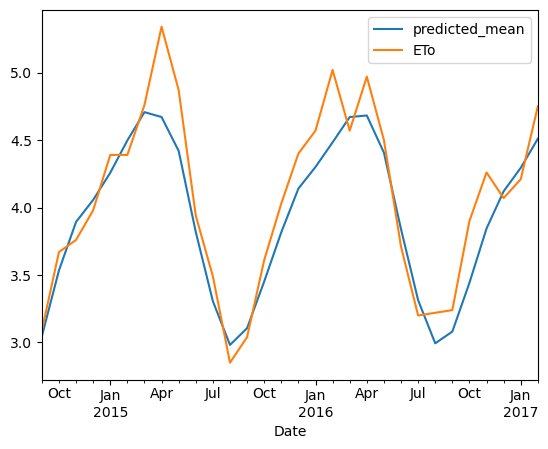

In [78]:
#Plot the prediction against the actual values and inspect the trend
prediction.plot(legend=True)
df_test.plot(legend=True)


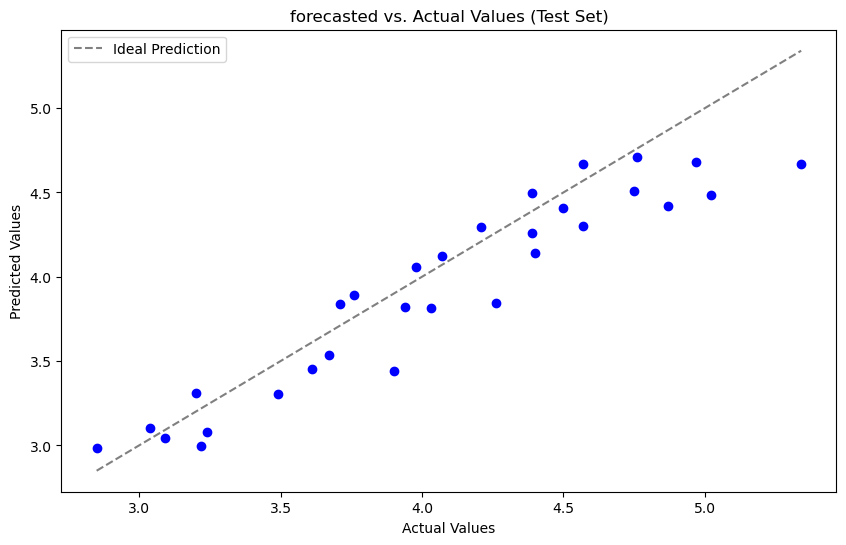

In [79]:
plt.figure(figsize=(10, 6))
plt.scatter(df_test, prediction, marker='o', color='blue')
plt.title('forecasted vs. Actual Values (Test Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(df_test), max(df_test)], [min(df_test), max(df_test)], linestyle='--', color='gray', label='Ideal Prediction')
plt.legend()
plt.show()

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
rmse = np.sqrt(mean_squared_error(df_test, prediction))
mae = mean_absolute_error(df_test, prediction)
rae = np.sum(np.abs(df_test - prediction)) / np.sum(np.abs(df_test - np.mean(df_test)))
r2 = r2_score(df_test, prediction)


print(f"RMSE: {rmse}")
print(f"RAE: {rae}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

RMSE: 0.2550804988572369
RAE: 0.3732862106934072
MAE: 0.20331655609100915
R2: 0.8453557305332025


### Autocorrelation and Partial Correlation plot to modify p and q values of the model

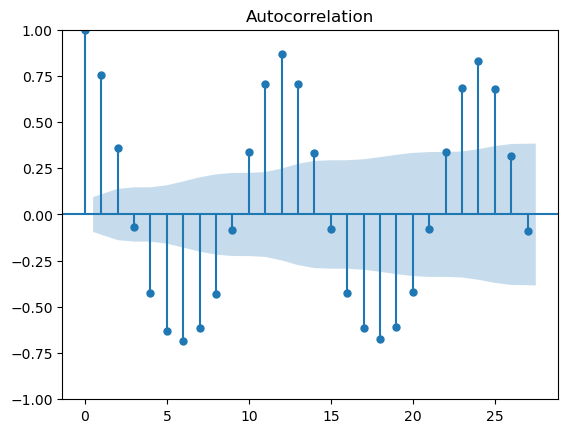

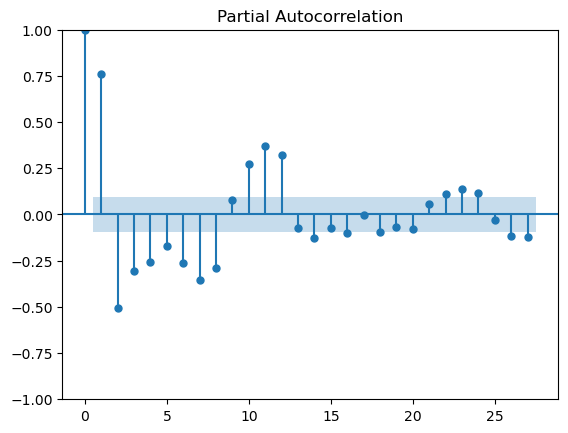

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_diff = plot_acf(df_train)

pacf_diff = plot_pacf(df_train)

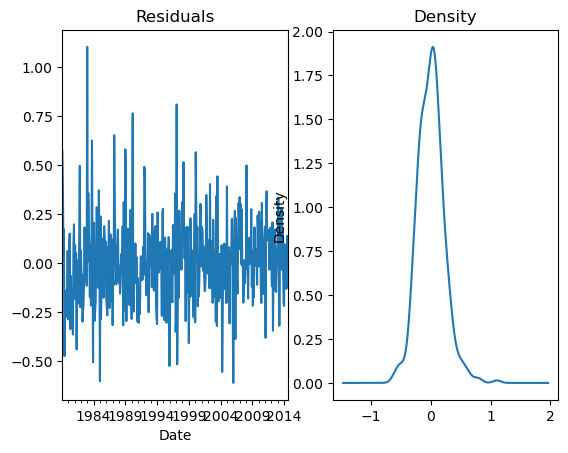

In [82]:
import matplotlib.pyplot as plt
residuals = model.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

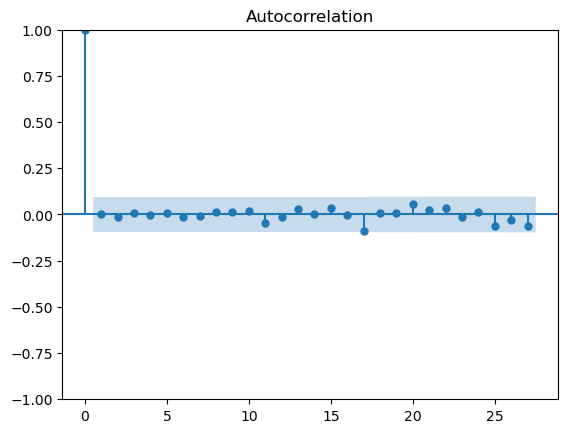

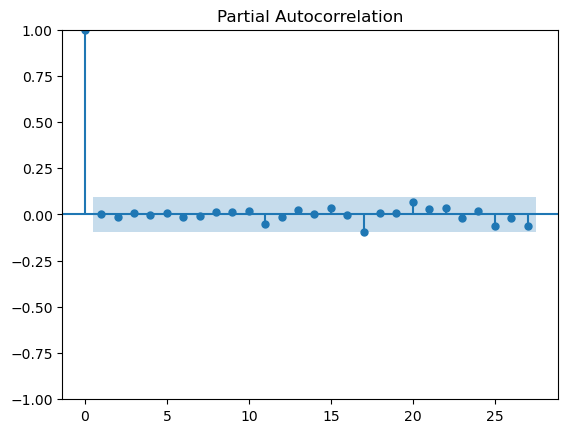

In [83]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

## TIME SERIES FORECASTING: XGBOOST

In [20]:
df = data[['ETo']]
df.index = pd.to_datetime(df.index)

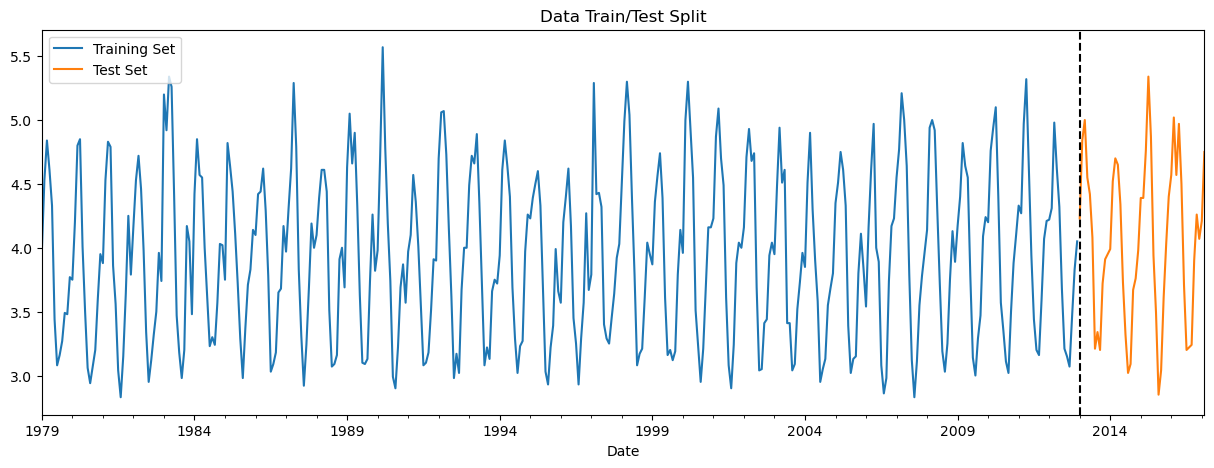

In [21]:
#Time series data split
train = df.loc[df.index < '01-01-2013']
test = df.loc[df.index >= '01-01-2013']

#Visualize the data split
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2013', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [36]:
#Create time features to use as input for the xgboost model
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
  
 #Create Lags to boost performance of the model   
    target_map = df['ETo'].to_dict()
    df['lag1'] = (df.index - pd.DateOffset(months=12)).map(target_map)
    df['lag2'] = (df.index - pd.DateOffset(months=24)).map(target_map)
    df['lag3'] = (df.index - pd.DateOffset(months=36)).map(target_map)
    return df

df = create_features(df)
df.tail()

,ETo,dayofweek,quarter,month,year,dayofyear,weekofyear,lag1,lag2,lag3
Date,,,,,,,,,,
2016-10-01,3.90,5,4,10,2016,275,39,3.61,3.67,3.72
2016-11-01,4.26,1,4,11,2016,306,44,4.03,3.76,3.91
2016-12-01,4.07,3,4,12,2016,336,48,4.40,3.98,3.95
2017-01-01,4.21,6,1,1,2017,1,52,4.57,4.39,3.99
2017-02-01,4.75,2,1,2,2017,32,5,5.02,4.39,4.52


In [35]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear','lag1','lag2','lag3']
TARGET = 'ETo'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [55]:
import xgboost as xgb
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=200,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[01:17:51] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.14392	validation_1-rmse:3.26020
[100]	validation_0-rmse:0.15611	validation_1-rmse:0.24707
[165]	validation_0-rmse:0.12973	validation_1-rmse:0.24613


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

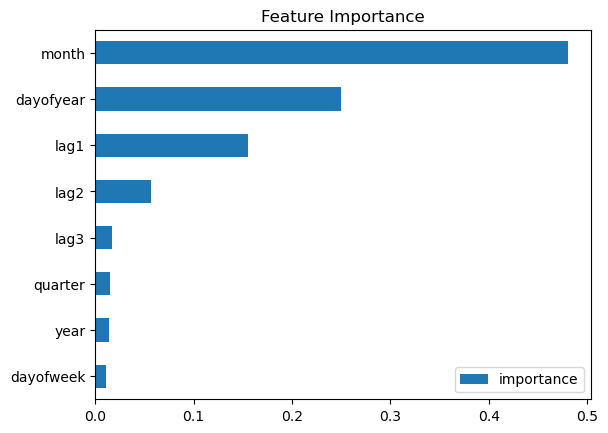

In [56]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

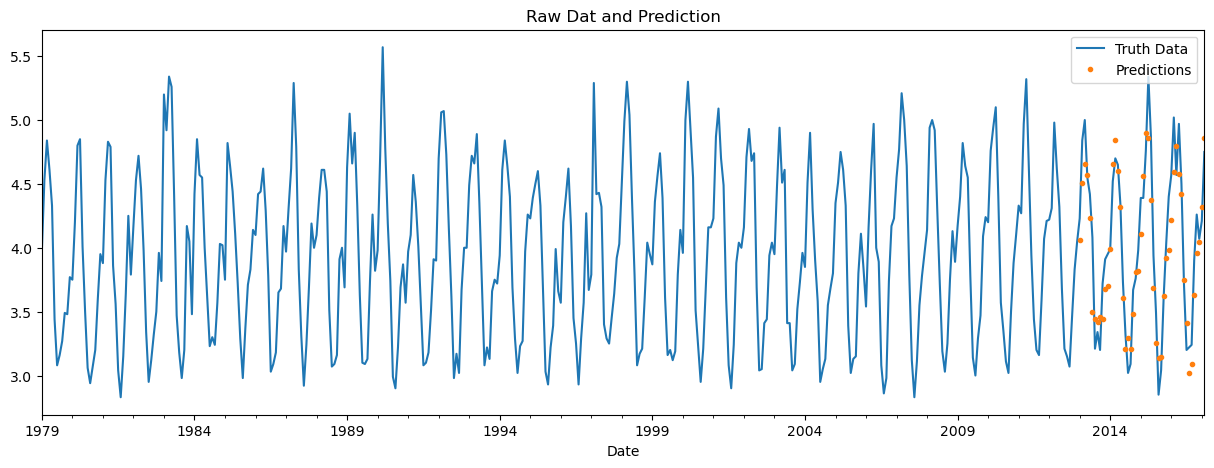

In [58]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['ETo']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

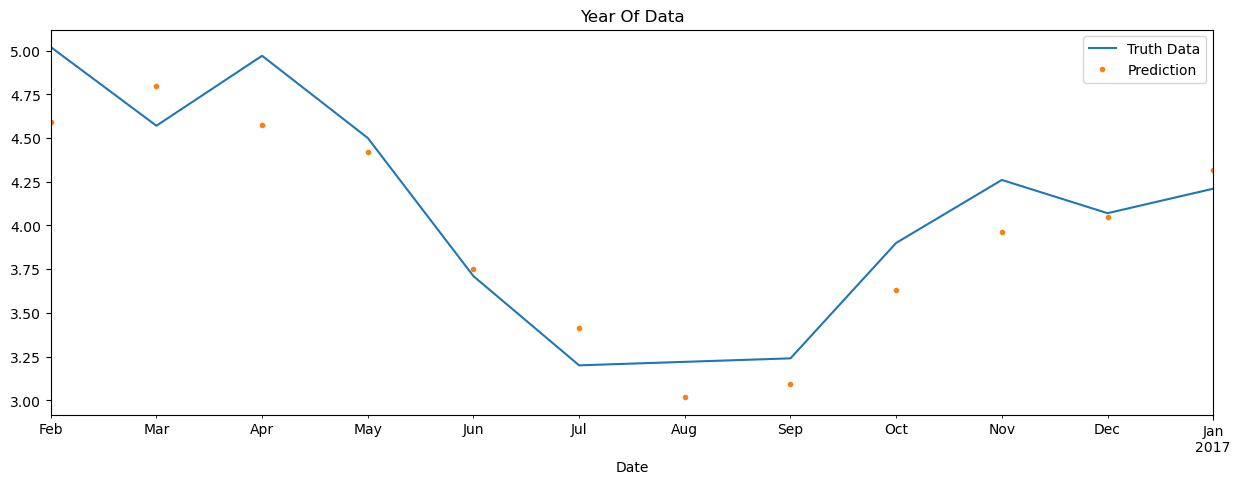

In [59]:
#Visualize the prediction against the true value
ax = df.loc[(df.index > '01-02-2016') & (df.index < '01-02-2017')]['ETo'] \
    .plot(figsize=(15, 5), title='Year Of Data')
df.loc[(df.index > '01-02-2016') & (df.index < '01-02-2017')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

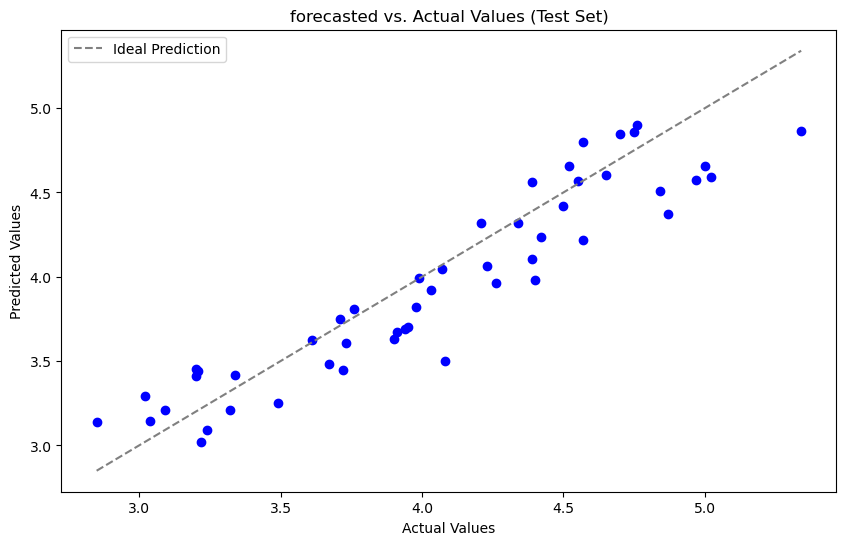

In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(test['ETo'], test['prediction'], marker='o', color='blue')
plt.title('forecasted vs. Actual Values (Test Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(test['ETo']), max(test['ETo'])], [min(test['ETo']), max(test['ETo'])], linestyle='--', color='gray', label='Ideal Prediction')
plt.legend()
plt.show()

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
rmse = np.sqrt(mean_squared_error(test['ETo'], test['prediction']))
mae = mean_absolute_error(test['ETo'], test['prediction'])
rae = np.sum(np.abs(test['ETo'] - test['prediction'])) / np.sum(np.abs(test['ETo'] - np.mean(test['ETo'])))
r2 = r2_score(test['ETo'], test['prediction'])


print(f"RMSE: {rmse}")
print(f"RAE: {rae}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

RMSE: 0.24453141410397497
RAE: 0.3885641518974596
MAE: 0.20422931823730472
R2: 0.846127067391589
